In [97]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

In [98]:
# Environment dimensions
AREA_WIDTH = 600
AREA_HEIGHT = 600

# Sensor and MC Parameters
NUM_SENSORS = 20
SENSOR_CAPACITY = 6000  # Joules
MC_CAPACITY = 1000000   # Joules
MC_SPEED = 5  # m/s
CHARGING_RATE = 20  # Joules per second
MOVEMENT_COST_PER_M = 5  # Joules per meter
THRESHOLD_RATIO = 0.2    # Time window opens when energy < 20% of capacity
CHARGING_RADIUS = 50     # Radius in meters within which MC can charge multiple nodes

In [99]:
class SensorNode:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
        self.capacity = SENSOR_CAPACITY
        self.energy = random.uniform(0.1, 1.4) * SENSOR_CAPACITY  # low enough to trigger window
        self.consumption_rate = random.uniform(0.5, 2.0)  # J/s
        self.dead = False
    
    def get_location(self):
        return (self.x, self.y)

    def update_energy(self, seconds):
        if not self.dead:
            self.energy -= self.consumption_rate * seconds
            if self.energy <= 0:
                self.energy = 0
                self.dead = True

    def needs_charging(self):
        return self.energy < (THRESHOLD_RATIO * self.capacity) and not self.dead

    def charge(self, amount):
        if not self.dead:
            self.energy += amount
            if self.energy > self.capacity:
                self.energy = self.capacity

In [100]:
class MobileCharger:
    def __init__(self, base_x=300, base_y=300):
        self.x = base_x
        self.y = base_y
        self.energy = MC_CAPACITY
        self.start_pos = (base_x, base_y)

    def move_to(self, x, y):
        distance = np.linalg.norm([self.x - x, self.y - y])
        cost = distance * MOVEMENT_COST_PER_M
        if self.energy < cost:
            return False  # not enough energy to move
        self.x, self.y = x, y
        self.energy -= cost
        return True

    def charge_node(self, node):
        if self.energy <= 0 or node.dead:
            return 0
        needed = node.capacity - node.energy
        energy_to_transfer = min(needed, self.energy)
        node.charge(energy_to_transfer)
        self.energy -= energy_to_transfer
        return energy_to_transfer
        
    def charge_nodes_in_radius(self, sensors):
        """Charge all sensor nodes within the charging radius"""
        charged_nodes = []
        total_energy_transferred = 0
        
        if self.energy <= 0:
            return charged_nodes, 0
            
        # Find sensors within the charging radius that need charging
        for sensor in sensors:
            if sensor.dead:
                continue
                
            distance = np.linalg.norm([self.x - sensor.x, self.y - sensor.y])
            if distance <= CHARGING_RADIUS and sensor.energy < sensor.capacity:
                needed = sensor.capacity - sensor.energy
                # Reduce charging efficiency with distance
                efficiency = max(0.3, 1 - (distance / CHARGING_RADIUS) * 0.7)  # 30% to 100% efficiency
                max_transfer = min(needed, self.energy)
                energy_to_transfer = max_transfer * efficiency
                
                if energy_to_transfer > 0:
                    sensor.charge(energy_to_transfer)
                    self.energy -= energy_to_transfer
                    total_energy_transferred += energy_to_transfer
                    charged_nodes.append(sensor.id)
                    
                    if self.energy <= 0:
                        break
                        
        return charged_nodes, total_energy_transferred

In [101]:
def initialize_environment(num_sensors=NUM_SENSORS):
    sensors = []
    for i in range(num_sensors):
        x = random.uniform(0, AREA_WIDTH)
        y = random.uniform(0, AREA_HEIGHT)
        sensors.append(SensorNode(i, x, y))
    mc = MobileCharger()
    return sensors, mc

In [102]:
def plot_environment(sensors, mc):
    """Basic visualization of the environment"""
    alive_x = [s.x for s in sensors if not s.dead]
    alive_y = [s.y for s in sensors if not s.dead]
    dead_x = [s.x for s in sensors if s.dead]
    dead_y = [s.y for s in sensors if s.dead]

    plt.figure(figsize=(8, 8))
    plt.scatter(alive_x, alive_y, c='green', label='Alive Sensors')
    plt.scatter(dead_x, dead_y, c='red', label='Dead Sensors')
    plt.scatter(mc.x, mc.y, c='blue', label='Mobile Charger (MC)', marker='X', s=100)
    plt.scatter(300, 300, c='black', label='Base Station', marker='s')
    
    # Draw charging radius
    circle = plt.Circle((mc.x, mc.y), CHARGING_RADIUS, color='blue', fill=False, linestyle='--', alpha=0.5)
    plt.gcf().gca().add_artist(circle)
    
    # Highlight nodes in charging range
    in_range_x = []
    in_range_y = []
    for s in sensors:
        if not s.dead:
            distance = np.linalg.norm([mc.x - s.x, mc.y - s.y])
            if distance <= CHARGING_RADIUS:
                in_range_x.append(s.x)
                in_range_y.append(s.y)
    
    if in_range_x:
        plt.scatter(in_range_x, in_range_y, c='yellow', edgecolors='orange', 
                   label='In Charging Range', s=80, zorder=3)
    
    plt.legend()
    plt.title("WRSN Environment")
    plt.grid(True)
    plt.xlim(0, AREA_WIDTH)
    plt.ylim(0, AREA_HEIGHT)
    plt.show()

In [103]:
def calculate_adaptive_priority(sensor, mc, alpha=0.3, beta=0.2, gamma=0.2, delta=0.3):
    """
    Calculate adaptive priority score for a sensor based on multiple factors:
    - Energy level percentage (lower % = higher priority)
    - Residual energy (lower absolute energy = higher priority)
    - Consumption rate (higher rate = higher priority)
    - Distance from MC (shorter distance = higher priority)
    
    Parameters:
    - alpha: weight for energy level percentage (0.0-1.0)
    - beta: weight for consumption rate factor (0.0-1.0)
    - gamma: weight for distance factor (0.0-1.0)
    - delta: weight for residual energy factor (0.0-1.0)
    
    Returns a priority score where higher values indicate higher priority
    """
    # 1. Normalize energy level percentage (lower energy % = higher priority)
    energy_ratio = sensor.energy / sensor.capacity
    energy_percentage_factor = 1 - energy_ratio  # invert so lower energy % = higher value
    
    # 2. Residual energy factor (lower absolute energy = higher priority)
    # Normalize against a reasonable minimum energy (e.g., 300J)
    min_critical_energy = 300  # Consider this as a critical minimum energy level in Joules
    residual_energy_factor = 1 - min(1, max(0, sensor.energy - min_critical_energy) / 
                                    (sensor.capacity - min_critical_energy))
    
    # 3. Normalize consumption rate (higher rate = higher priority)
    max_consumption_rate = 2.0
    consumption_factor = min(sensor.consumption_rate / max_consumption_rate, 1.0)
    
    # 4. Normalize distance (shorter distance = higher priority)
    distance = np.linalg.norm([mc.x - sensor.x, mc.y - sensor.y])
    max_distance = np.sqrt(AREA_WIDTH**2 + AREA_HEIGHT**2)
    distance_factor = 1 - (distance / max_distance)  # invert so closer = higher value
    
    # Calculate urgency based on remaining time until death
    if sensor.consumption_rate > 0:
        time_to_death = sensor.energy / sensor.consumption_rate
        # Normalize: anything under 100 seconds is urgent, over 1000 seconds is not urgent
        urgency_factor = max(0, min(1, 1 - (time_to_death - 100) / 900))
    else:
        urgency_factor = 0
    
    # Combine factors with weights
    # Note that alpha + beta + gamma + delta should ideally sum to 1.0
    priority = (alpha * energy_percentage_factor + 
                beta * consumption_factor + 
                gamma * distance_factor +
                delta * residual_energy_factor) * (1 + urgency_factor)
    
    return priority

In [104]:
def get_sensors_needing_charging(sensors, mc, adaptive_threshold=True, fixed_threshold_ratio=THRESHOLD_RATIO):
    """
    Get sensors needing charging, either using a fixed threshold or an adaptive approach.
    
    Parameters:
    - sensors: list of SensorNode objects
    - mc: MobileCharger object
    - adaptive_threshold: whether to use adaptive thresholds (True) or fixed (False)
    - fixed_threshold_ratio: ratio to use if using fixed threshold
    
    Returns list of sensors that need charging, sorted by priority
    """
    if not adaptive_threshold:
        # Original approach: fixed threshold
        to_charge = [s for s in sensors if s.needs_charging()]
        # Sort by distance (closest first)
        to_charge.sort(key=lambda s: np.linalg.norm([mc.x - s.x, mc.y - s.y]))
        return to_charge
    
    # Adaptive approach:
    # Calculate priority for all sensors
    sensor_priorities = []
    for sensor in sensors:
        if sensor.dead:
            continue
            
        # Calculate priority score
        priority = calculate_adaptive_priority(sensor, mc)
        
        # Add to list if priority exceeds minimum threshold
        # Higher energy sensors might still be charged if they're very close and 
        # have high consumption rate
        min_priority_threshold = 0.15  # Only consider sensors with some level of need
        if priority > min_priority_threshold:
            sensor_priorities.append((sensor, priority))
    
    # Sort by priority (highest first)
    sensor_priorities.sort(key=lambda x: x[1], reverse=True)
    
    # Return just the sensors in priority order
    return [s for s, _ in sensor_priorities]

In [105]:
def simulate_step_adaptive(sensors, mc, time_step=10):
    """Simulation step using adaptive charging threshold"""
    # 1. Update energy of all sensors
    for s in sensors:
        s.update_energy(time_step)

    # 2. Get sensors needing charging using adaptive threshold
    to_charge = get_sensors_needing_charging(sensors, mc, adaptive_threshold=True)
    
    if not to_charge:
        print("No sensor needs charging right now.")
        return False

    # 3. Select the highest priority sensor (first in list)
    target = to_charge[0]
    
    # 4. Move to sensor
    if not mc.move_to(target.x, target.y):
        print("MC does not have enough energy to move.")
        return False

    # 5. Charge all sensors within radius
    charged_nodes, total_energy = mc.charge_nodes_in_radius(sensors)
    
    if charged_nodes:
        print(f"Charged {len(charged_nodes)} sensors with total {total_energy:.2f} J")
        print(f"Sensor IDs charged: {charged_nodes}")
    else:
        print("No sensors were charged in this step.")

    return True

In [106]:
def run_adaptive_continuous_charging(num_steps=15, time_step=3, num_sensors=50, path_segments=8):
    """
    Run a simulation with adaptive charging threshold and continuous charging while moving.
    """
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    
    # Initialize environment
    sensors, mc = initialize_environment(num_sensors=num_sensors)
    
    # Set varied energy levels and consumption rates
    for i, s in enumerate(sensors):
        if i % 5 == 0:  # 20% very low
            s.energy = 0.05 * s.capacity
        elif i % 5 == 1:  # 20% low
            s.energy = 0.2 * s.capacity
        elif i % 5 == 2:  # 20% medium
            s.energy = 0.5 * s.capacity
            
        # Vary consumption rates to create different priorities
        if i % 3 == 0:  # High consumption
            s.consumption_rate = random.uniform(0.8, 1.5)
        elif i % 3 == 1:  # Medium consumption
            s.consumption_rate = random.uniform(0.4, 0.7)
        else:  # Low consumption
            s.consumption_rate = random.uniform(0.1, 0.3)
    
    # Path tracking
    path_x = [mc.x]
    path_y = [mc.y]
    path_history = [(mc.x, mc.y)]  # Initialize path_history as list of tuples
    charging_events = []
    total_energy_transferred = 0
    
    # Run simulation
    for step in range(num_steps):
        print(f"--- Step {step+1}/{num_steps} --- MC Energy: {mc.energy:.1f}J")
        
        # Get sensors needing charging using adaptive threshold
        to_charge = get_sensors_needing_charging(sensors, mc, adaptive_threshold=True)
        
        if not to_charge:
            # Let energy deplete a bit
            for s in sensors:
                s.update_energy(time_step * 2)
            print("No sensors need charging right now.")
            continue
        
        # Show priorities of top 3 sensors
        print("Top priority sensors:")
        for i, sensor in enumerate(to_charge[:3]):
            priority = calculate_adaptive_priority(sensor, mc)
            energy_pct = sensor.energy / sensor.capacity * 100
            print(f"  {i+1}. Sensor {sensor.id}: Priority={priority:.2f}, Energy={energy_pct:.1f}%, " +
                  f"Rate={sensor.consumption_rate:.2f}J/s, " +
                  f"Distance={np.linalg.norm([mc.x - sensor.x, mc.y - sensor.y]):.1f}m")
        
        # Select highest priority sensor
        target = to_charge[0]
        
        # Save current position
        start_point = (mc.x, mc.y)
        end_point = (target.x, target.y)
        
        # Move and charge continuously
        energy_transferred, charged_node_ids, path_segment_x, path_segment_y = move_and_charge_along_path(
            mc, start_point, end_point, sensors, path_segments=path_segments
        )
        
        # Update tracking
        path_x.extend(path_segment_x[1:])
        path_y.extend(path_segment_y[1:])
        
        # Update path_history with new path segments
        for i in range(1, len(path_segment_x)):  # Skip first point to avoid duplication
            path_history.append((path_segment_x[i], path_segment_y[i]))
        
        total_energy_transferred += energy_transferred
        
        if charged_node_ids:
            print(f"Charged {len(charged_node_ids)} sensors with {energy_transferred:.1f}J while moving")
            charging_events.append((mc.x, mc.y, step+1))
        
        # Update energy of all sensors
        for s in sensors:
            s.update_energy(time_step)
        
        # Visualize priorities - NOW PASSING THE PATH HISTORY
        print("Visualizing sensor priorities...")
        visualize_sensor_priorities(sensors, mc, path_history)
    
    # Show final stats
    dead_count = sum(1 for s in sensors if s.dead)
    print(f"\nSimulation complete after {num_steps} steps:")
    print(f"Total energy transferred: {total_energy_transferred:.1f}J")
    print(f"Sensors dead: {dead_count} out of {num_sensors}")
    print(f"MC remaining energy: {mc.energy:.1f}J")

In [107]:
def move_and_charge_along_path(mc, start_point, end_point, sensors, path_segments=10):
    """
    Moves the mobile charger from start to end point in small increments,
    charging sensors within radius at each step along the path.
    """
    start_x, start_y = start_point
    end_x, end_y = end_point
    
    # Calculate total distance and movement cost
    total_distance = np.linalg.norm([end_x - start_x, end_y - start_y])
    movement_cost = total_distance * MOVEMENT_COST_PER_M
    
    if mc.energy < movement_cost:
        return 0, [], [mc.x], [mc.y]  # Not enough energy to complete move
    
    # Deduct movement cost upfront
    mc.energy -= movement_cost
    
    # Create path points (divide path into segments)
    path_x = []
    path_y = []
    
    # Statistics tracking
    total_energy_transferred = 0
    all_charged_nodes = []
    
    # Move along the path in increments, charging at each step
    for i in range(path_segments + 1):  # +1 to include end point
        # Calculate position at this segment
        progress = i / path_segments
        current_x = start_x + (end_x - start_x) * progress
        current_y = start_y + (end_y - start_y) * progress
        
        # Update charger position
        mc.x, mc.y = current_x, current_y
        path_x.append(current_x)
        path_y.append(current_y)
        
        # Charge sensors within radius at reduced efficiency while moving
        charged_nodes, energy_transferred = charge_while_moving(mc, sensors)
        
        if charged_nodes:
            total_energy_transferred += energy_transferred
            all_charged_nodes.extend([node_id for node_id in charged_nodes if node_id not in all_charged_nodes])
            
    return total_energy_transferred, all_charged_nodes, path_x, path_y

In [108]:
def charge_while_moving(mc, sensors):
    """Charge all sensors within radius while the charger is moving"""
    charged_nodes = []
    total_energy_transferred = 0
    
    if mc.energy <= 0:
        return charged_nodes, 0
    
    # Apply a movement efficiency factor (reduced efficiency while moving)
    movement_efficiency_factor = 0.7  # 70% as effective as stationary charging
    
    # Check all sensors
    for sensor in sensors:
        if sensor.dead:
            continue
            
        distance = np.linalg.norm([mc.x - sensor.x, mc.y - sensor.y])
        # Check if sensor is within charging radius
        if distance <= CHARGING_RADIUS:
            needed = sensor.capacity - sensor.energy
            if needed <= 0:
                continue  # Skip fully charged sensors
                
            # Calculate efficiency based on distance + movement penalty
            base_efficiency = max(0.3, 1 - (distance / CHARGING_RADIUS) * 0.7)
            moving_efficiency = base_efficiency * movement_efficiency_factor
            
            # Calculate energy to transfer
            max_transfer = min(needed, mc.energy)
            energy_to_transfer = max_transfer * moving_efficiency
            
            if energy_to_transfer > 0:
                sensor.charge(energy_to_transfer)
                mc.energy -= energy_to_transfer
                total_energy_transferred += energy_to_transfer
                charged_nodes.append(sensor.id)
                
                if mc.energy <= 0:
                    break
    
    return charged_nodes, total_energy_transferred

In [109]:
def run_adaptive_continuous_charging(num_steps=15, time_step=3, num_sensors=50, path_segments=8):
    """
    Run a simulation with adaptive charging threshold and continuous charging while moving.
    """
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    
    # Initialize environment
    sensors, mc = initialize_environment(num_sensors=num_sensors)
    
    # Set varied energy levels and consumption rates
    for i, s in enumerate(sensors):
        if i % 5 == 0:  # 20% very low
            s.energy = 0.05 * s.capacity
        elif i % 5 == 1:  # 20% low
            s.energy = 0.2 * s.capacity
        elif i % 5 == 2:  # 20% medium
            s.energy = 0.5 * s.capacity
            
        # Vary consumption rates to create different priorities
        if i % 3 == 0:  # High consumption
            s.consumption_rate = random.uniform(0.8, 1.5)
        elif i % 3 == 1:  # Medium consumption
            s.consumption_rate = random.uniform(0.4, 0.7)
        else:  # Low consumption
            s.consumption_rate = random.uniform(0.1, 0.3)
    
    # Path tracking
    path_x = [mc.x]
    path_y = [mc.y]
    path_history = [(mc.x, mc.y)]  # Initialize path_history as list of tuples
    charging_events = []
    total_energy_transferred = 0
    
    # Run simulation
    for step in range(num_steps):
        print(f"--- Step {step+1}/{num_steps} --- MC Energy: {mc.energy:.1f}J")
        
        # Get sensors needing charging using adaptive threshold
        to_charge = get_sensors_needing_charging(sensors, mc, adaptive_threshold=True)
        
        if not to_charge:
            # Let energy deplete a bit
            for s in sensors:
                s.update_energy(time_step * 2)
            print("No sensors need charging right now.")
            continue
        
        # Show priorities of top 3 sensors
        print("Top priority sensors:")
        for i, sensor in enumerate(to_charge[:3]):
            priority = calculate_adaptive_priority(sensor, mc)
            energy_pct = sensor.energy / sensor.capacity * 100
            print(f"  {i+1}. Sensor {sensor.id}: Priority={priority:.2f}, Energy={energy_pct:.1f}%, " +
                  f"Rate={sensor.consumption_rate:.2f}J/s, " +
                  f"Distance={np.linalg.norm([mc.x - sensor.x, mc.y - sensor.y]):.1f}m")
        
        # Select highest priority sensor
        target = to_charge[0]
        
        # Save current position
        start_point = (mc.x, mc.y)
        end_point = (target.x, target.y)
        
        # Move and charge continuously
        energy_transferred, charged_node_ids, path_segment_x, path_segment_y = move_and_charge_along_path(
            mc, start_point, end_point, sensors, path_segments=path_segments
        )
        
        # Update tracking
        path_x.extend(path_segment_x[1:])
        path_y.extend(path_segment_y[1:])
        
        # Update path_history with new path segments
        for i in range(1, len(path_segment_x)):  # Skip first point to avoid duplication
            path_history.append((path_segment_x[i], path_segment_y[i]))
        
        total_energy_transferred += energy_transferred
        
        if charged_node_ids:
            print(f"Charged {len(charged_node_ids)} sensors with {energy_transferred:.1f}J while moving")
            charging_events.append((mc.x, mc.y, step+1))
        
        # Update energy of all sensors
        for s in sensors:
            s.update_energy(time_step)
        
        # Visualize priorities - NOW PASSING THE PATH HISTORY
        print("Visualizing sensor priorities...")
        visualize_sensor_priorities(sensors, mc, path_history)
    
    # Show final stats
    dead_count = sum(1 for s in sensors if s.dead)
    print(f"\nSimulation complete after {num_steps} steps:")
    print(f"Total energy transferred: {total_energy_transferred:.1f}J")
    print(f"Sensors dead: {dead_count} out of {num_sensors}")
    print(f"MC remaining energy: {mc.energy:.1f}J")

In [110]:
def visualize_sensor_priorities(sensors, mc, path_history=None):
    """Visualize sensors with their adaptive priority scores and path history"""
    plt.figure(figsize=(12, 10))
    
    # Calculate priorities for all alive sensors
    sensor_priorities = []
    for s in sensors:
        if not s.dead:
            priority = calculate_adaptive_priority(s, mc)
            sensor_priorities.append((s, priority))
    
    # Normalize priorities for visualization
    max_priority = max(p for _, p in sensor_priorities) if sensor_priorities else 1.0
    
    # Plot sensors with color based on priority
    for s, priority in sensor_priorities:
        # Normalize to 0-1 range
        norm_priority = priority / max_priority
        
        # Use color scale: red (high priority) to blue (low priority)
        color = [norm_priority, 0, 1-norm_priority]
        size = 50 + norm_priority * 100  # Size also reflects priority
        
        plt.scatter(s.x, s.y, c=[color], s=size, alpha=0.7, edgecolors='black')
        
        # Show priority score and sensor ID
        plt.annotate(f"ID:{s.id}\nP:{priority:.2f}", (s.x, s.y), 
                    xytext=(5, 5), textcoords="offset points", fontsize=8)
        
        # Show energy level
        energy_pct = s.energy / s.capacity * 100
        plt.annotate(f"{energy_pct:.0f}%", (s.x, s.y), 
                    xytext=(5, -10), textcoords="offset points", fontsize=7,
                    color='green' if energy_pct > 50 else 'red')
    
    # Plot dead sensors
    dead_x = [s.x for s in sensors if s.dead]
    dead_y = [s.y for s in sensors if s.dead]
    if dead_x:
        plt.scatter(dead_x, dead_y, c='black', marker='x', s=100, label='Dead Sensors')
    
    # Plot MC
    plt.scatter(mc.x, mc.y, c='blue', marker='X', s=150, label='Mobile Charger')
    plt.scatter(300, 300, c='black', marker='s', label='Base Station')
    
    # Draw charging radius
    circle = plt.Circle((mc.x, mc.y), CHARGING_RADIUS, color='blue', 
                       fill=False, linestyle='--', alpha=0.5)
    plt.gcf().gca().add_artist(circle)
    
    # Plot path history if available
    if path_history and len(path_history) > 1:
        path_x, path_y = zip(*path_history)
        plt.plot(path_x, path_y, 'b-', alpha=0.4, linewidth=2, label='MC Path')
    
    # Legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor='red', edgecolor='black', label='High Priority'),
        Patch(facecolor='purple', edgecolor='black', label='Medium Priority'),
        Patch(facecolor='blue', edgecolor='black', label='Low Priority'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor='blue', markersize=10, label='Mobile Charger')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title("Sensor Nodes with Adaptive Priority Visualization")
    plt.grid(True)
    plt.xlim(0, AREA_WIDTH)
    plt.ylim(0, AREA_HEIGHT)
    plt.show()

Initial sensor priorities:


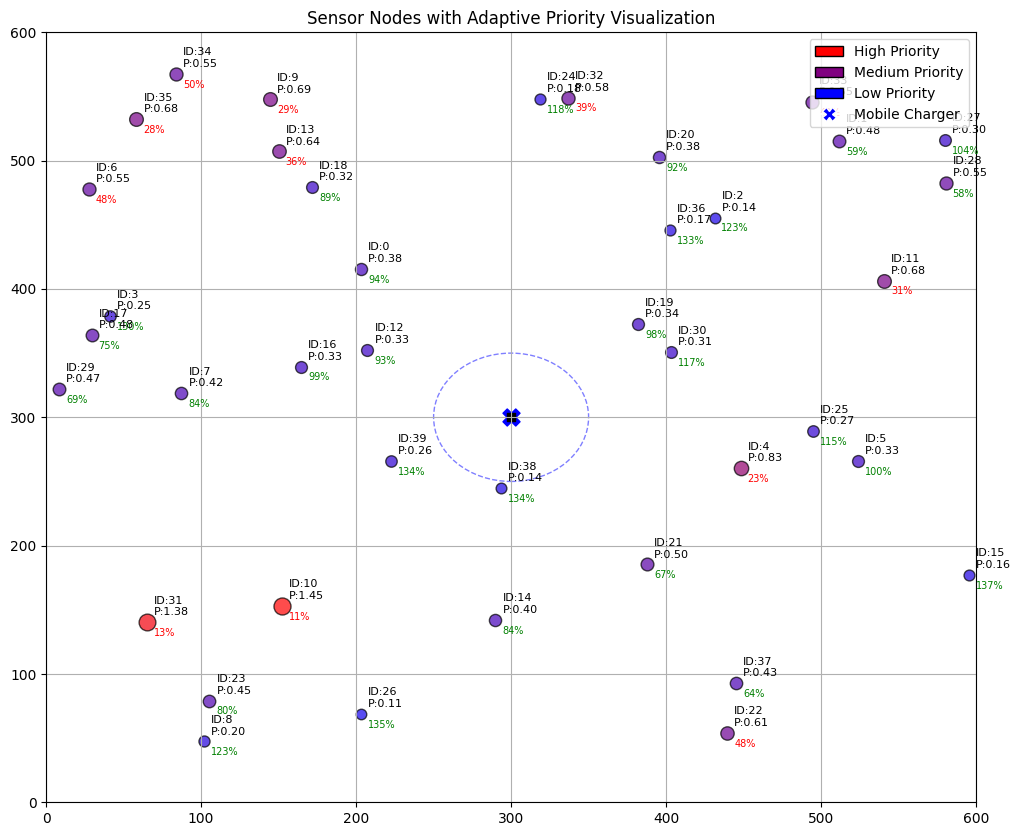

--- Step 1/10 --- MC Energy: 1000000.0J
Top priority sensors:
  1. Sensor 30: Priority=1.55, Energy=5.0%, Rate=1.10J/s, Distance=159.3m
  2. Sensor 15: Priority=1.41, Energy=5.0%, Rate=0.93J/s, Distance=305.5m
  3. Sensor 0: Priority=1.37, Energy=5.0%, Rate=0.85J/s, Distance=297.0m
Charged 3 sensors with 9643.7J while moving
Visualizing sensor priorities...


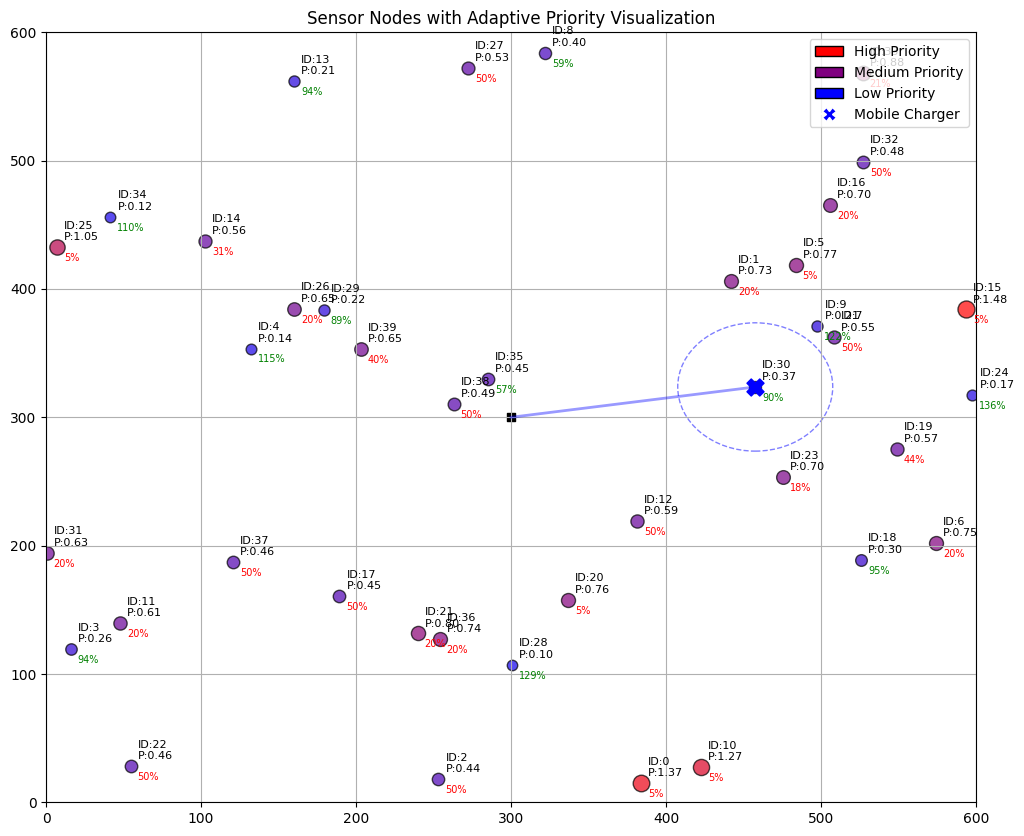

--- Step 2/10 --- MC Energy: 989560.0J
Top priority sensors:
  1. Sensor 15: Priority=1.48, Energy=5.0%, Rate=0.93J/s, Distance=149.0m
  2. Sensor 0: Priority=1.37, Energy=5.0%, Rate=0.85J/s, Distance=317.3m
  3. Sensor 10: Priority=1.27, Energy=5.0%, Rate=0.68J/s, Distance=298.2m
Charged 3 sensors with 8501.0J while moving
Visualizing sensor priorities...


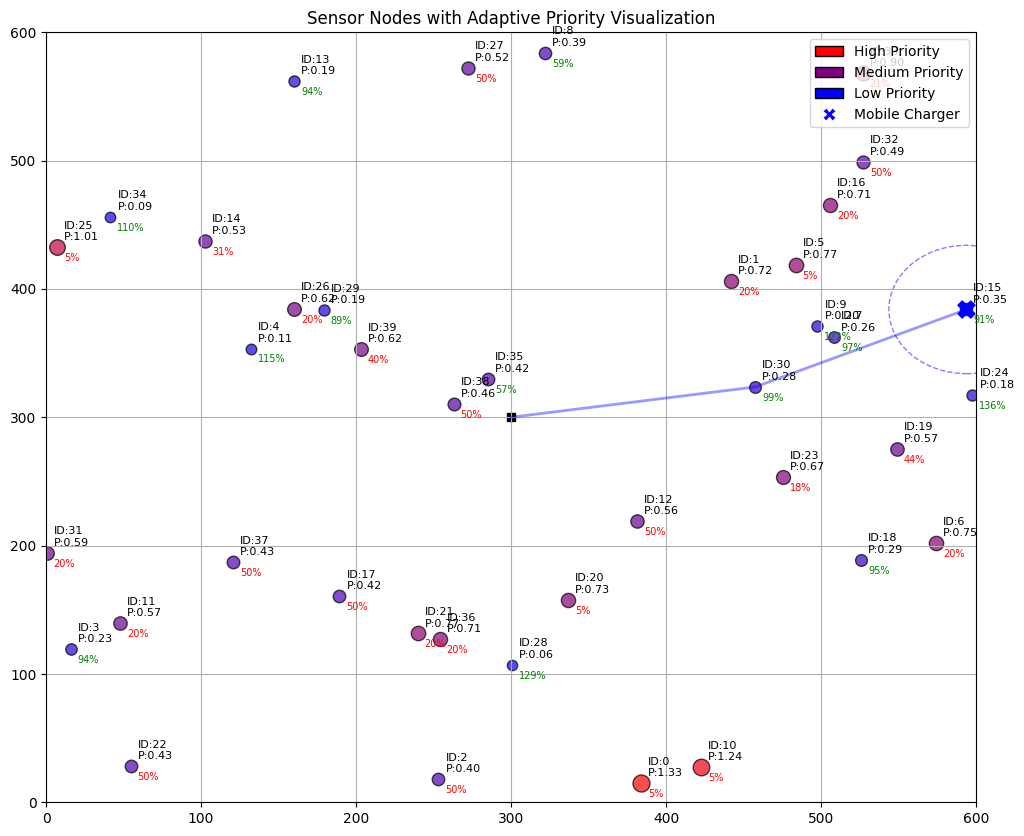

--- Step 3/10 --- MC Energy: 980314.1J
Top priority sensors:
  1. Sensor 0: Priority=1.33, Energy=4.9%, Rate=0.85J/s, Distance=424.6m
  2. Sensor 10: Priority=1.24, Energy=4.9%, Rate=0.68J/s, Distance=395.4m
  3. Sensor 25: Priority=1.01, Energy=4.9%, Rate=0.50J/s, Distance=588.8m
Charged 6 sensors with 11211.7J while moving
Visualizing sensor priorities...


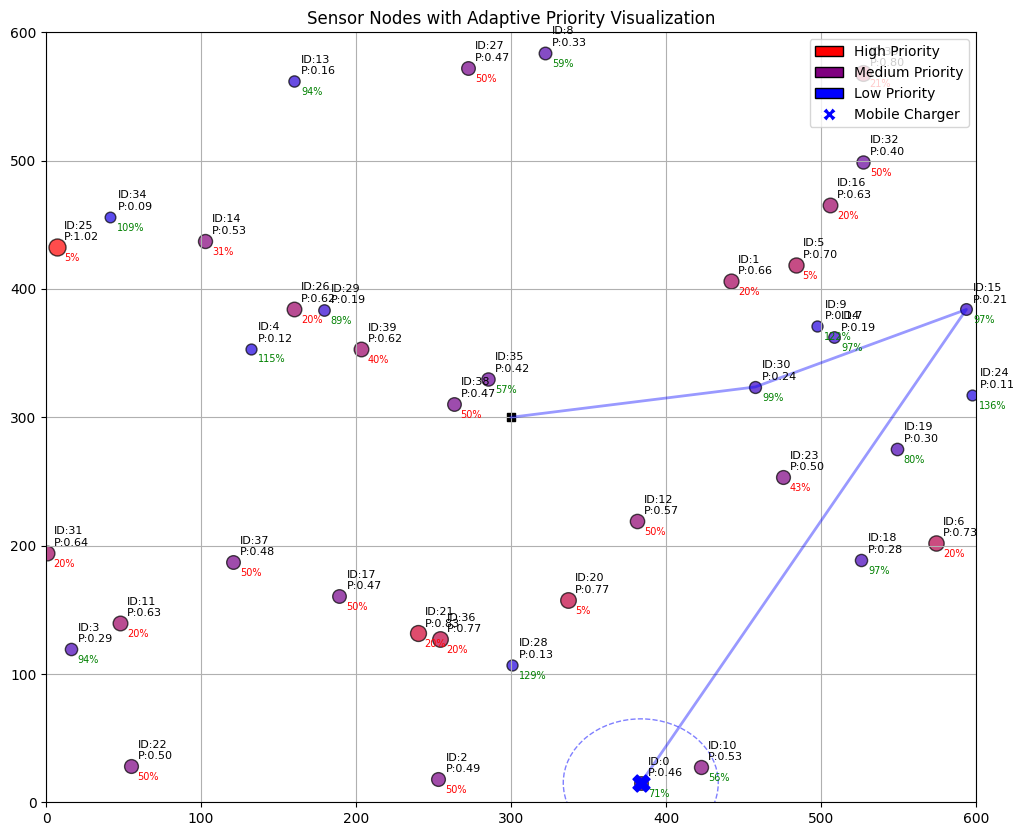

--- Step 4/10 --- MC Energy: 966979.4J
Top priority sensors:
  1. Sensor 25: Priority=1.02, Energy=4.9%, Rate=0.50J/s, Distance=562.3m
  2. Sensor 21: Priority=0.83, Energy=19.8%, Rate=1.27J/s, Distance=185.3m
  3. Sensor 33: Priority=0.80, Energy=20.9%, Rate=1.45J/s, Distance=571.4m
Charged 5 sensors with 9892.9J while moving
Visualizing sensor priorities...


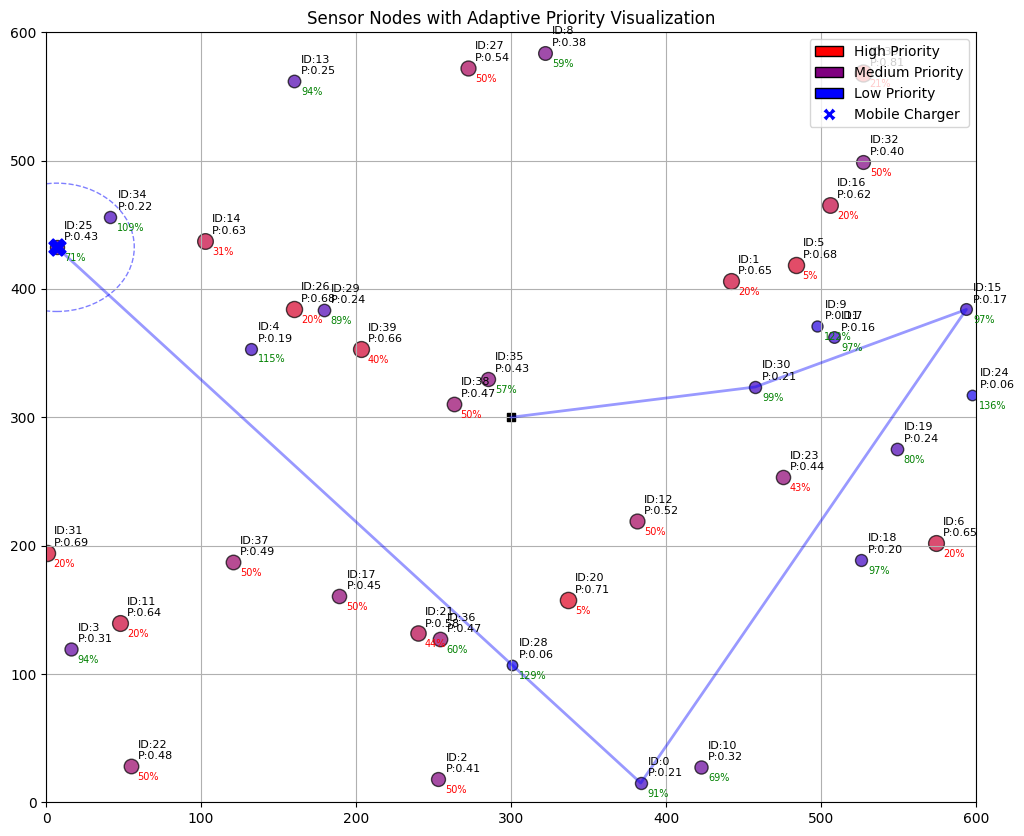

--- Step 5/10 --- MC Energy: 954274.9J
Top priority sensors:
  1. Sensor 33: Priority=0.81, Energy=20.8%, Rate=1.45J/s, Distance=537.3m
  2. Sensor 20: Priority=0.71, Energy=5.0%, Rate=0.25J/s, Distance=429.4m
  3. Sensor 31: Priority=0.69, Energy=19.9%, Rate=0.48J/s, Distance=238.0m
Charged 3 sensors with 6750.1J while moving
Visualizing sensor priorities...


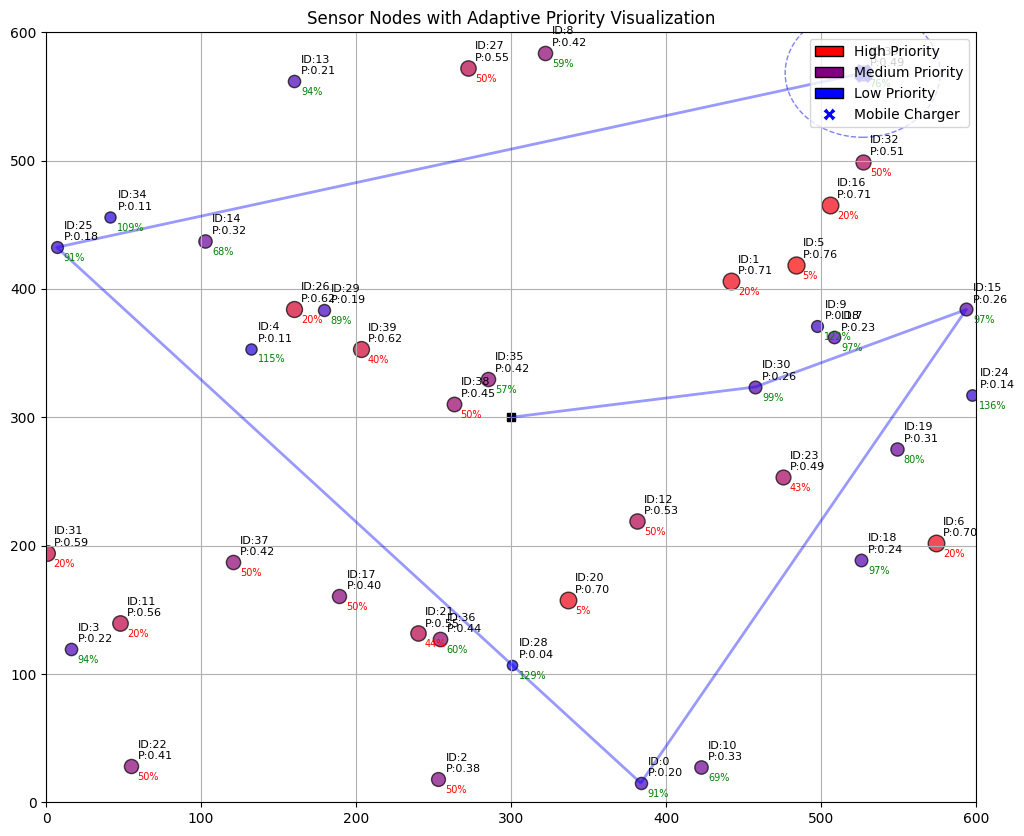

--- Step 6/10 --- MC Energy: 944838.2J
Top priority sensors:
  1. Sensor 5: Priority=0.76, Energy=5.0%, Rate=0.11J/s, Distance=155.4m
  2. Sensor 16: Priority=0.71, Energy=19.9%, Rate=0.43J/s, Distance=104.7m
  3. Sensor 1: Priority=0.71, Energy=19.9%, Rate=0.59J/s, Distance=183.0m
Charged 5 sensors with 14971.6J while moving
Visualizing sensor priorities...


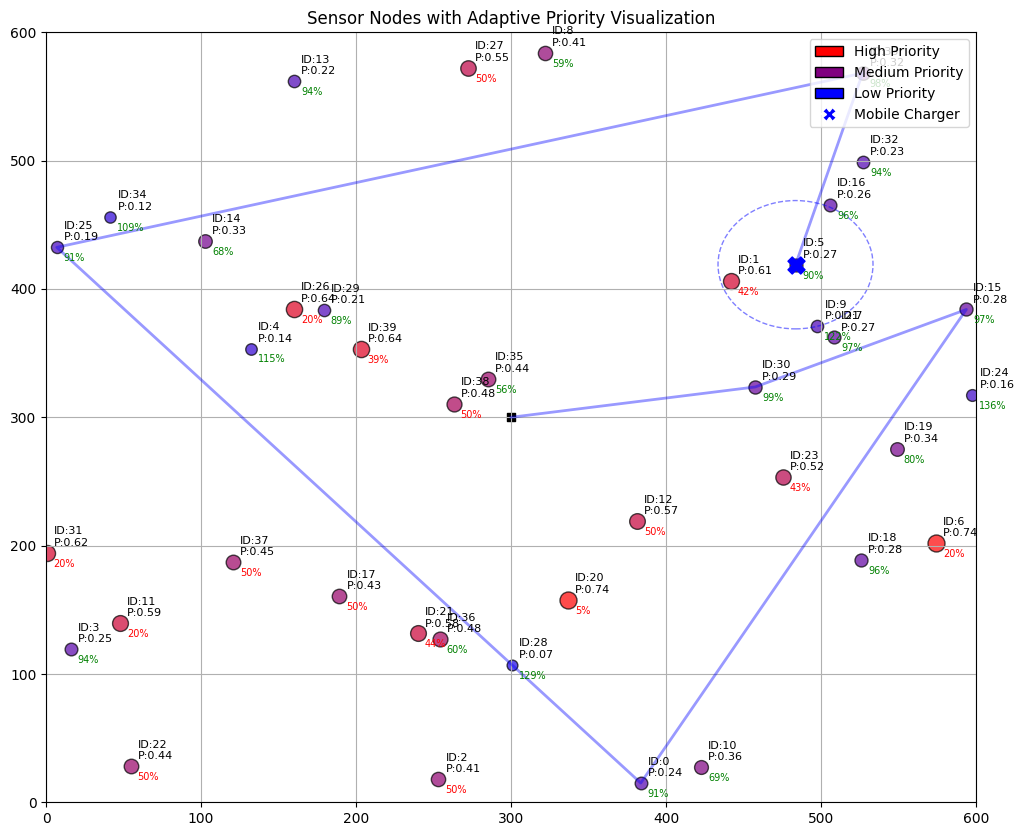

--- Step 7/10 --- MC Energy: 929089.3J
Top priority sensors:
  1. Sensor 20: Priority=0.74, Energy=4.9%, Rate=0.25J/s, Distance=299.6m
  2. Sensor 6: Priority=0.74, Energy=19.7%, Rate=0.97J/s, Distance=235.2m
  3. Sensor 26: Priority=0.64, Energy=19.9%, Rate=0.27J/s, Distance=325.2m
Charged 6 sensors with 9566.2J while moving
Visualizing sensor priorities...


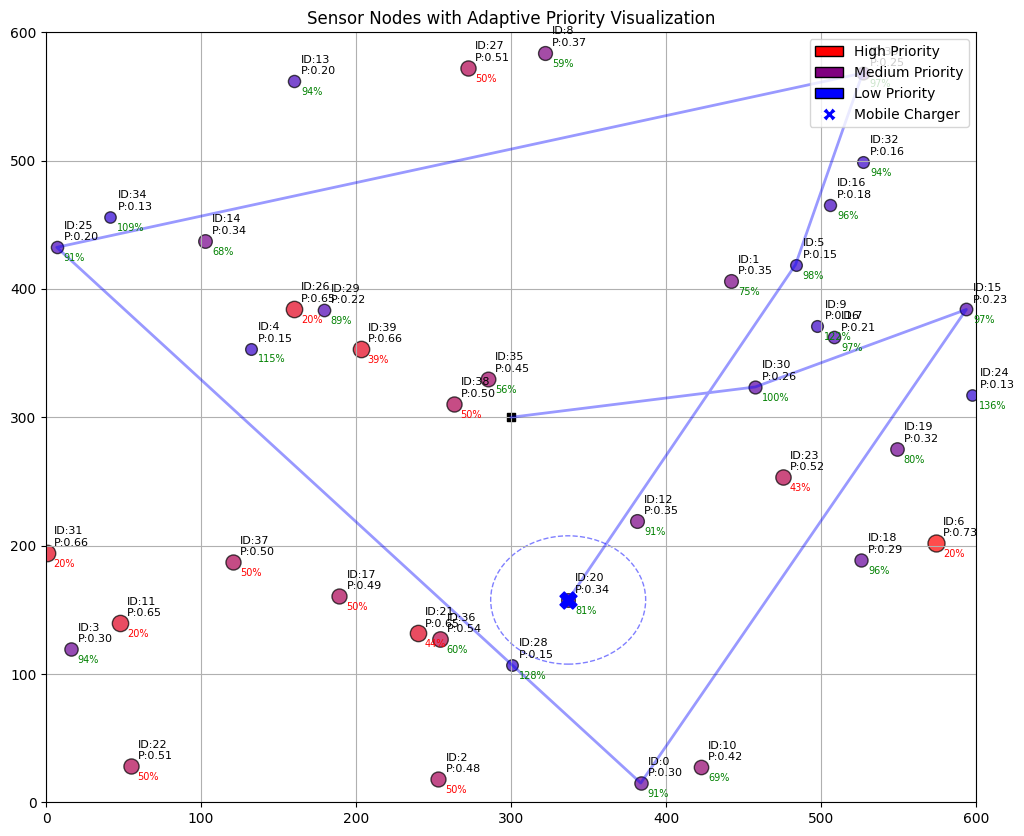

--- Step 8/10 --- MC Energy: 918025.2J
Top priority sensors:
  1. Sensor 6: Priority=0.73, Energy=19.7%, Rate=0.97J/s, Distance=241.6m
  2. Sensor 31: Priority=0.66, Energy=19.8%, Rate=0.48J/s, Distance=338.5m
  3. Sensor 39: Priority=0.66, Energy=39.4%, Rate=1.39J/s, Distance=236.9m
Charged 3 sensors with 5081.8J while moving
Visualizing sensor priorities...


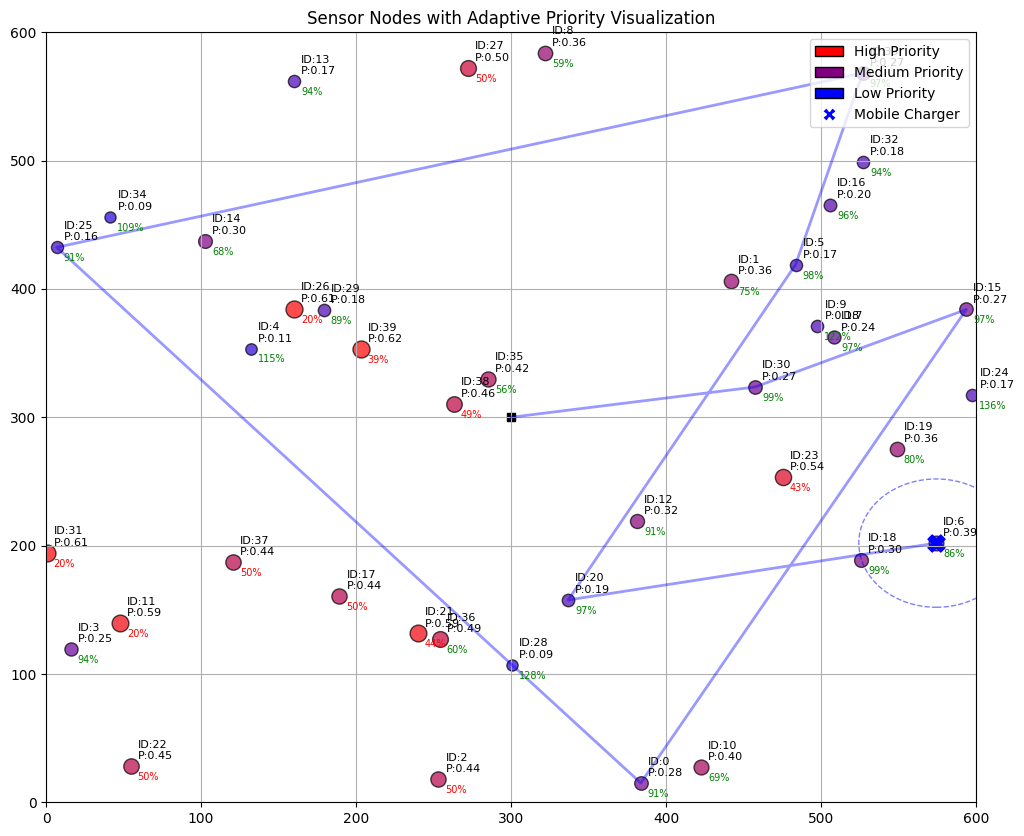

--- Step 9/10 --- MC Energy: 911735.4J
Top priority sensors:
  1. Sensor 39: Priority=0.62, Energy=39.4%, Rate=1.39J/s, Distance=401.0m
  2. Sensor 26: Priority=0.61, Energy=19.9%, Rate=0.27J/s, Distance=452.7m
  3. Sensor 31: Priority=0.61, Energy=19.8%, Rate=0.48J/s, Distance=574.0m
Charged 7 sensors with 9482.8J while moving
Visualizing sensor priorities...


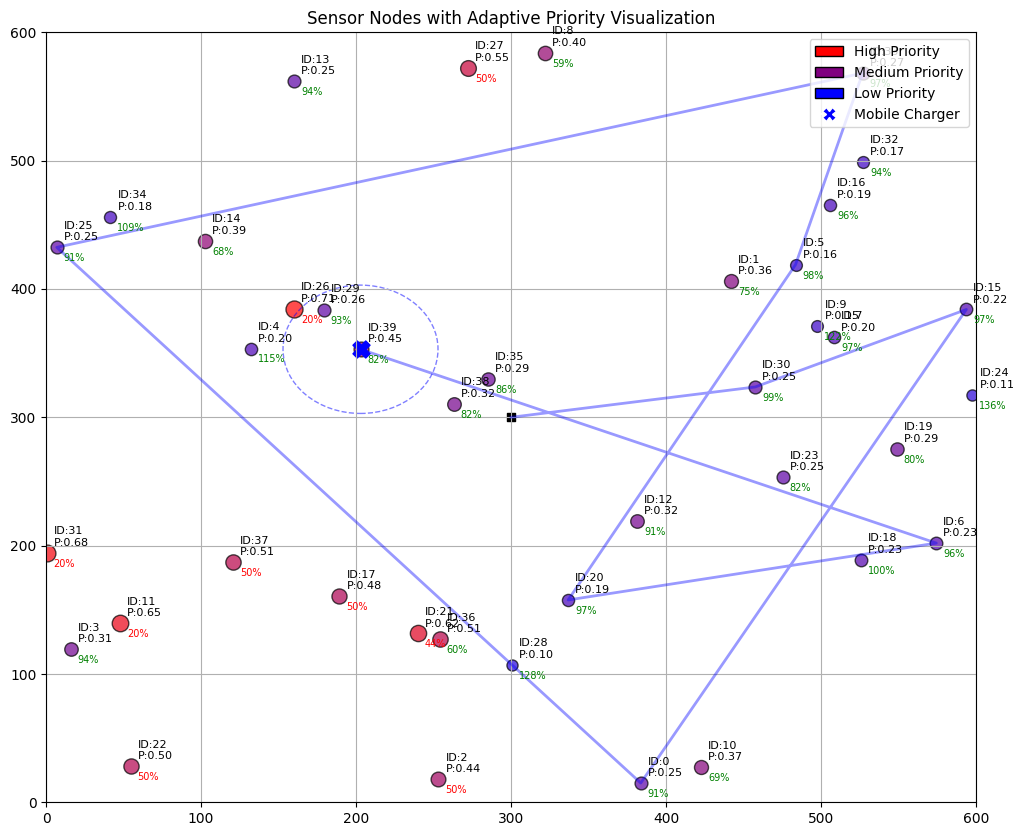

--- Step 10/10 --- MC Energy: 900247.5J
Top priority sensors:
  1. Sensor 26: Priority=0.71, Energy=19.9%, Rate=0.27J/s, Distance=53.2m
  2. Sensor 31: Priority=0.68, Energy=19.8%, Rate=0.48J/s, Distance=257.2m
  3. Sensor 11: Priority=0.65, Energy=19.9%, Rate=0.21J/s, Distance=263.7m
Charged 3 sensors with 6321.5J while moving
Visualizing sensor priorities...


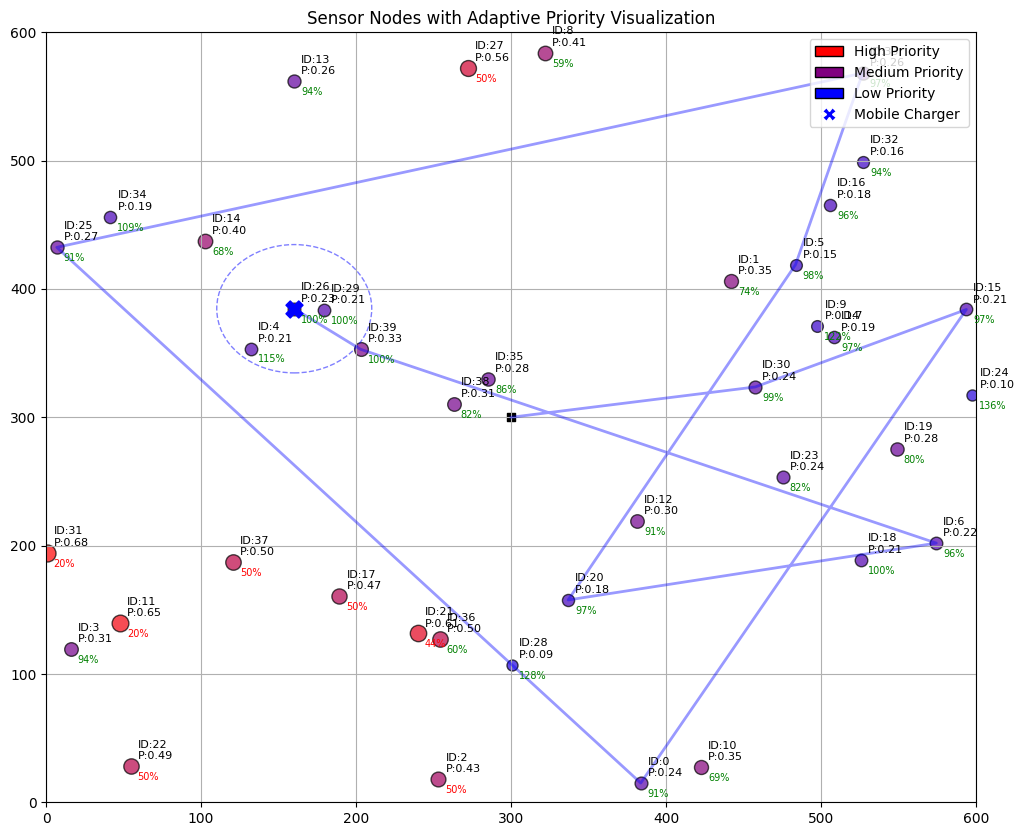


Simulation complete after 10 steps:
Total energy transferred: 91423.2J
Sensors dead: 0 out of 40
MC remaining energy: 893660.2J


In [112]:
# Example of running the simulation
sensors, mc = initialize_environment(num_sensors=40)

# Create an empty path history for the initial visualization
path_history = [(mc.x, mc.y)]  # Start with current position of MC

# Visualize initial priorities
print("Initial sensor priorities:")
visualize_sensor_priorities(sensors, mc, path_history)

# Run the adaptive charging simulation
run_adaptive_continuous_charging(
    num_steps=10,      # Number of steps to run
    time_step=3,       # Time between updates
    num_sensors=40,    # Number of sensors
    path_segments=8    # Segments for continuous charging
)